In [2]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn
from sklearn import linear_model
import requests
import patsy
import scipy.stats as stats
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Import and cleaning data

In [3]:
# Import drom 'Movies_data_collection.ipynb'
df_comb=pd.read_csv('df_combo_genres.csv')
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 28 columns):
Unnamed: 0          521 non-null int64
Year                521 non-null int64
Title               521 non-null object
ProductionBudget    521 non-null int64
DomesticGross       521 non-null int64
WorldwideGross      521 non-null int64
runtimeMinutes      521 non-null int64
Rating IMDb         521 non-null float64
numVotes            521 non-null int64
Action              521 non-null int64
Adventure           521 non-null int64
Biography           521 non-null int64
Comedy              521 non-null int64
Crime               521 non-null int64
Drama               521 non-null int64
Family              521 non-null int64
History             521 non-null int64
Horror              521 non-null int64
Music               521 non-null int64
Mystery             521 non-null int64
Romance             521 non-null int64
Sport               521 non-null int64
Thriller            521 non-null i

In [4]:
#Import prom "Oscar.ipynb"
oscar=pd.read_csv('oscar2.csv')
oscar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
Unnamed: 0     418 non-null int64
Awards         418 non-null int64
Film           418 non-null object
Nominations    418 non-null int64
dtypes: int64(3), object(1)
memory usage: 13.1+ KB


In [5]:
oscar.head() 

Unnamed: 0  Awards               Film  Nominations
0           0       3         Green Book            5
1           1       4  Bohemian Rhapsody            5
2           2       3               Roma           10
3           3       3      Black Panther            7
4           4       1      The Favourite           10

In [6]:
#Delete column, rename in oscar
oscar.drop(['Unnamed: 0'], 1, inplace=True)
oscar = oscar.rename(columns={"Film": "Title"})

In [7]:
#Delete column, rename in df_combo
df_combo = df_comb.rename(columns={"Rating IMDb": "Rating_IMDb", "numVotes": "Popularity"})
df_combo.drop(['Unnamed: 0'], 1, inplace=True)
df_combo.head() 

Year                                        Title  ProductionBudget  \
0  2009                                       Avatar         425000000   
1  2011  Pirates of the Caribbean: On Stranger Tides         410600000   
2  2019                            Avengers: Endgame         400000000   
3  2015                      Avengers: Age of Ultron         330600000   
4  2018                       Avengers: Infinity War         300000000   

   DomesticGross  WorldwideGross  runtimeMinutes  Rating_IMDb  Popularity  \
0      760507625      2789705275             162          7.8     1049384   
1      241063875      1045663875             136          6.6      449280   
2      858373000      2795473000             181          8.7      470989   
3      459005868      1403013963             141          7.3      670766   
4      678815482      2048134200             149          8.5      682591   

   Action  Adventure  ...  Music  Mystery  Romance  Sport  Thriller  War  \
0       1          1  ...      0        0        0      0         0    0   
1       1          1  ...      0        0        0      0         0    0   
2       1          1  ...      0        0        0      0         0    0   
3       1          1  ...      0        0        0      0         0    0   
4       1          1  ...      0        0        0      0         0    0   

   Western  Fantasy  Animation  Sci-Fi  
0        0        1          0       0  
1        0        1          0       0  
2        0        0          0       1  
3        0        0          0       1  
4        0        0          0       1  

[5 rows x 27 columns]

In [8]:
#Merge two dataframes
df_combo2 = pd.merge(df_combo, oscar,  how='left', on=['Title'])
df_combo2.fillna(0, inplace=True)
df_combo2.head()

Year                                        Title  ProductionBudget  \
0  2009                                       Avatar         425000000   
1  2011  Pirates of the Caribbean: On Stranger Tides         410600000   
2  2019                            Avengers: Endgame         400000000   
3  2015                      Avengers: Age of Ultron         330600000   
4  2018                       Avengers: Infinity War         300000000   

   DomesticGross  WorldwideGross  runtimeMinutes  Rating_IMDb  Popularity  \
0      760507625      2789705275             162          7.8     1049384   
1      241063875      1045663875             136          6.6      449280   
2      858373000      2795473000             181          8.7      470989   
3      459005868      1403013963             141          7.3      670766   
4      678815482      2048134200             149          8.5      682591   

   Action  Adventure  ...  Romance  Sport  Thriller  War  Western  Fantasy  \
0       1          1  ...        0      0         0    0        0        1   
1       1          1  ...        0      0         0    0        0        1   
2       1          1  ...        0      0         0    0        0        0   
3       1          1  ...        0      0         0    0        0        0   
4       1          1  ...        0      0         0    0        0        0   

   Animation  Sci-Fi  Awards  Nominations  
0          0       0     3.0          9.0  
1          0       0     0.0          0.0  
2          0       1     0.0          0.0  
3          0       1     0.0          0.0  
4          0       1     0.0          0.0  

[5 rows x 29 columns]

In [9]:
#Remove outliers and zeros
df_combo2 = df_combo2[(df_combo2['Rating_IMDb'] >=4)]
df_combo2 = df_combo2[(df_combo2['DomesticGross'] >0)]
df_combo2 = df_combo2[(df_combo2['WorldwideGross'] >0)]
df_combo2 = df_combo2[(df_combo2['runtimeMinutes'] >0)]
df_combo2 = df_combo2[(df_combo2['Popularity'] <1700000)]
df_combo2 = df_combo2.select_dtypes(exclude=['object'])
df_combo2 = df_combo2[['Rating_IMDb', 'Year', 'ProductionBudget','WorldwideGross', "DomesticGross", "runtimeMinutes", "Popularity", 'Action', 'Adventure', 'Biography', 'Comedy', "Crime", "Drama", "Family", "History", "Horror", "Music", "Mystery", "Romance", "Sport", "Thriller", "War", "Western", "Fantasy", "Animation", "Sci-Fi", "Awards", "Nominations"]]
df_combo2.describe()

Rating_IMDb         Year  ProductionBudget  WorldwideGross  \
count   511.000000   511.000000      5.110000e+02    5.110000e+02   
mean      6.650685  2008.927593      1.322679e+08    4.137484e+08   
std       0.878833     6.424573      5.166308e+07    3.423417e+08   
min       4.100000  1991.000000      8.000000e+07    1.851732e+07   
25%       6.100000  2004.000000      9.000000e+07    1.847018e+08   
50%       6.600000  2010.000000      1.200000e+08    3.152684e+08   
75%       7.300000  2014.000000      1.600000e+08    5.337448e+08   
max       8.900000  2019.000000      4.250000e+08    2.795473e+09   

       DomesticGross  runtimeMinutes    Popularity      Action   Adventure  \
count   5.110000e+02      511.000000  5.110000e+02  511.000000  511.000000   
mean    1.532892e+08      118.882583  2.734390e+05    0.608611    0.679061   
std     1.184260e+08       22.099018  2.411393e+05    0.488539    0.467295   
min     1.001732e+07       76.000000  1.268500e+04    0.000000    0.000000   
25%     7.194183e+07      102.000000  1.100950e+05    0.000000    0.000000   
50%     1.253055e+08      116.000000  2.019790e+05    1.000000    1.000000   
75%     1.981759e+08      132.000000  3.717015e+05    1.000000    1.000000   
max     8.583730e+08      201.000000  1.518269e+06    1.000000    1.000000   

        Biography  ...     Romance       Sport    Thriller         War  \
count  511.000000  ...  511.000000  511.000000  511.000000  511.000000   
mean     0.019569  ...    0.041096    0.009785    0.140900    0.011742   
std      0.138651  ...    0.198707    0.098529    0.348259    0.107827   
min      0.000000  ...    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  ...    0.000000    0.000000    0.000000    0.000000   
50%      0.000000  ...    0.000000    0.000000    0.000000    0.000000   
75%      0.000000  ...    0.000000    0.000000    0.000000    0.000000   
max      1.000000  ...    1.000000    1.000000    1.000000    1.000000   

          Western     Fantasy   Animation      Sci-Fi      Awards  Nominations  
count  511.000000  511.000000  511.000000  511.000000  511.000000   511.000000  
mean     0.005871    0.168297    0.185910    0.232877    0.287671     0.626223  
std      0.076471    0.374497    0.389415    0.423079    1.068912     2.118827  
min      0.000000    0.000000    0.000000    0.000000    0.000000     0.000000  
25%      0.000000    0.000000    0.000000    0.000000    0.000000     0.000000  
50%      0.000000    0.000000    0.000000    0.000000    0.000000     0.000000  
75%      0.000000    0.000000    0.000000    0.000000    0.000000     0.000000  
max      1.000000    1.000000    1.000000    1.000000   11.000000    14.000000  

[8 rows x 28 columns]

# Visualisations, EDA

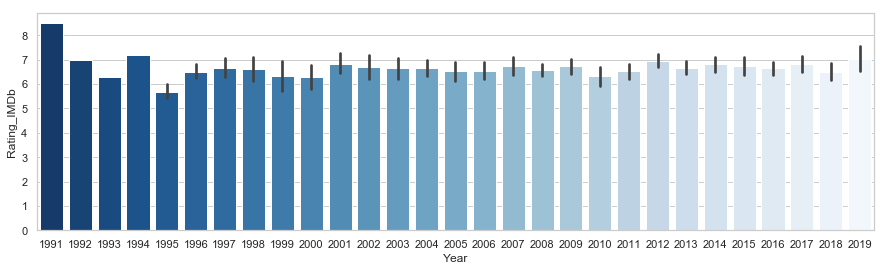

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 4))
sns.barplot(x='Year', y= 'Rating_IMDb', data=df_combo2,  palette="Blues_r");

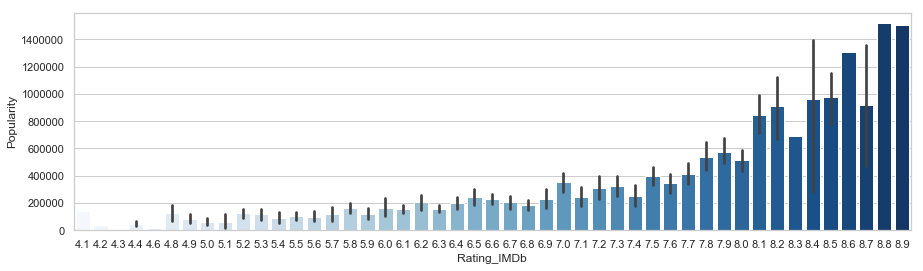

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 4))
sns.barplot(y='Popularity', x = 'Rating_IMDb', data=df_combo2,  palette="Blues");

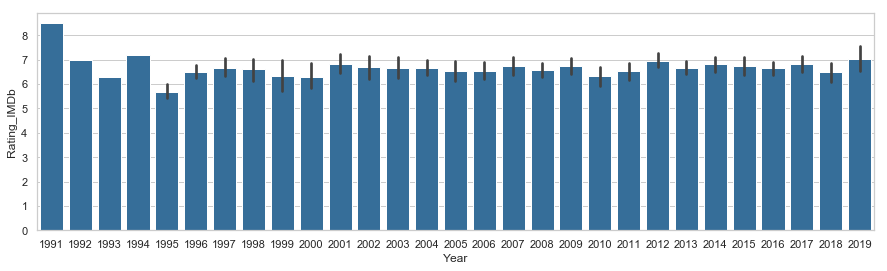

In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 4))
sns.barplot(x='Year', y= 'Rating_IMDb', data=df_combo2, color="#2670A9");

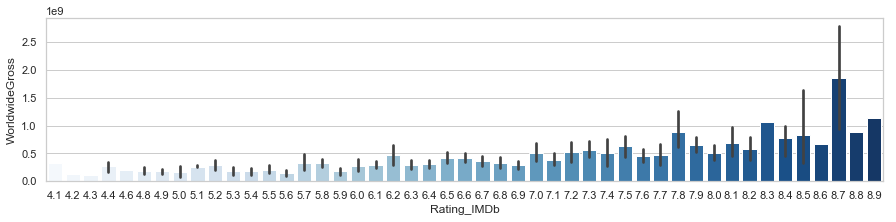

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.barplot(y='WorldwideGross', x = 'Rating_IMDb', data=df_combo2,  palette="Blues");

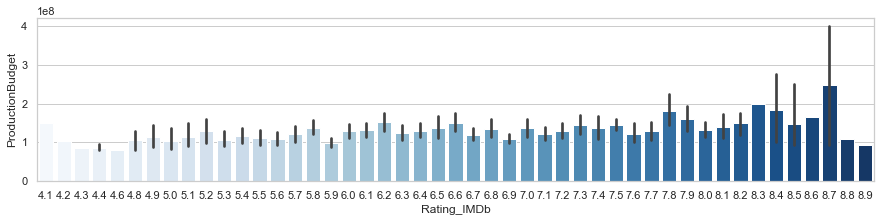

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.barplot(y='ProductionBudget', x = 'Rating_IMDb', data=df_combo2,  palette="Blues");

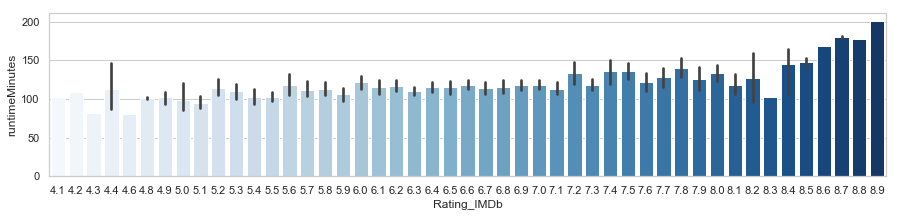

In [15]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 3))
sns.barplot(y='runtimeMinutes', x = 'Rating_IMDb', data=df_combo2,  palette="Blues");

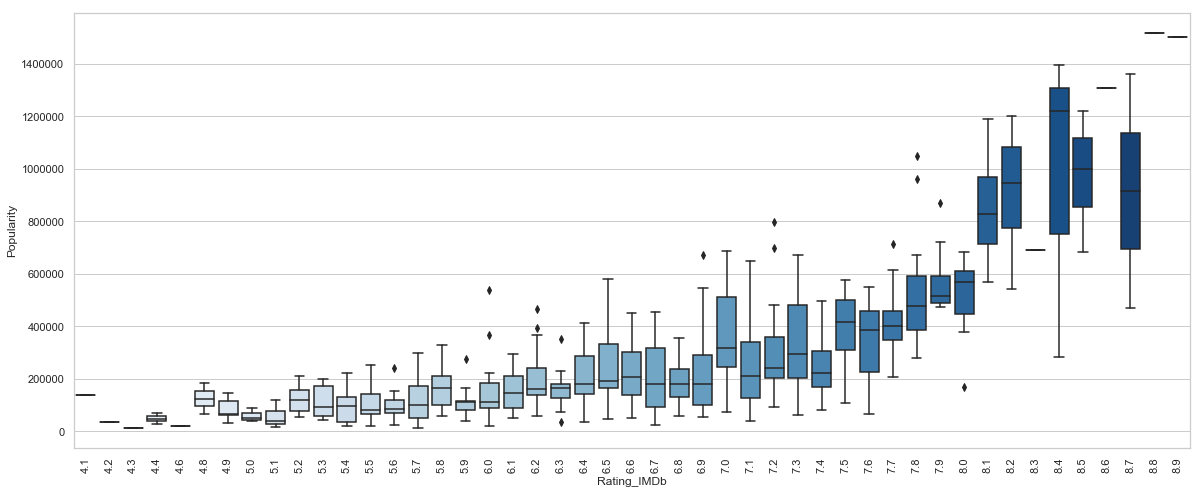

In [16]:
# Group by Popularity and visualize the it's mean points.
ranks = df_combo2.groupby('Rating_IMDb').Popularity.mean().sort_values()[::-1].index
plt.figure(figsize=(20,8), )
sns.boxplot(x="Rating_IMDb", y="Popularity", data=df_combo2,  palette="Blues")
plt.xticks(rotation=90);
#color="#f45d50"

# Correlation of columns

In [17]:
df_combo2.corr()

Rating_IMDb      Year  ProductionBudget  WorldwideGross  \
Rating_IMDb          1.000000  0.060904          0.198164        0.442653   
Year                 0.060904  1.000000          0.380891        0.280809   
ProductionBudget     0.198164  0.380891          1.000000        0.637968   
WorldwideGross       0.442653  0.280809          0.637968        1.000000   
DomesticGross        0.469111  0.183354          0.539244        0.923490   
runtimeMinutes       0.397030 -0.011550          0.298216        0.317023   
Popularity           0.681069  0.016574          0.302443        0.554140   
Action              -0.090256  0.100904          0.186230        0.048674   
Adventure            0.027751  0.278965          0.334187        0.263225   
Biography            0.110922  0.001594         -0.065471       -0.069799   
Comedy              -0.177900 -0.009268         -0.192270       -0.108351   
Crime                0.032281 -0.187686         -0.204149       -0.155290   
Drama                0.205420 -0.121866         -0.185457       -0.153372   
Family              -0.119276 -0.003189          0.001271       -0.017434   
History              0.074192 -0.110488         -0.062363       -0.097454   
Horror              -0.115970 -0.038028         -0.026738       -0.061499   
Music                0.053498  0.078839         -0.012470        0.074996   
Mystery              0.075771 -0.085078         -0.124396       -0.090579   
Romance             -0.061355 -0.111324         -0.124653       -0.062244   
Sport                0.012377 -0.048440         -0.075630       -0.081909   
Thriller             0.006731 -0.127762         -0.139275       -0.061069   
War                  0.057852 -0.080854         -0.065683       -0.077402   
Western              0.050998  0.056742          0.033846       -0.027620   
Fantasy             -0.081971  0.064567          0.123991        0.078771   
Animation            0.111637  0.044578         -0.032401        0.038686   
Sci-Fi              -0.006494  0.058877          0.197242        0.158551   
Awards               0.363708 -0.068342          0.075526        0.286194   
Nominations          0.392327 -0.067963          0.076795        0.251965   

                  DomesticGross  runtimeMinutes  Popularity    Action  \
Rating_IMDb            0.469111        0.397030    0.681069 -0.090256   
Year                   0.183354       -0.011550    0.016574  0.100904   
ProductionBudget       0.539244        0.298216    0.302443  0.186230   
WorldwideGross         0.923490        0.317023    0.554140  0.048674   
DomesticGross          1.000000        0.269733    0.588547  0.032837   
runtimeMinutes         0.269733        1.000000    0.495038  0.156285   
Popularity             0.588547        0.495038    1.000000  0.059589   
Action                 0.032837        0.156285    0.059589  1.000000   
Adventure              0.210371       -0.086631    0.062745  0.127220   
Biography             -0.065557        0.202970    0.034760 -0.089334   
Comedy                -0.058077       -0.468561   -0.255470 -0.421251   
Crime                 -0.119332        0.056212    0.000305  0.026428   
Drama                 -0.146803        0.332550    0.106345 -0.174128   
Family                -0.016808       -0.145485   -0.158540 -0.357860   
History               -0.078447        0.138218   -0.041325 -0.074152   
Horror                -0.062416       -0.033165   -0.061762 -0.060387   
Music                  0.098489       -0.005345   -0.013660 -0.078167   
Mystery               -0.071253        0.147496    0.050327 -0.041178   
Romance               -0.055811        0.093085   -0.055432 -0.157161   
Sport                 -0.057039        0.066266   -0.069638 -0.083223   
Thriller              -0.094487        0.044701    0.011707  0.105797   
War                   -0.076692        0.099324   -0.017912 -0.024256   
Western               -0.024753        0.104833    0.082514  0.009141   
Fantasy                0.041206 

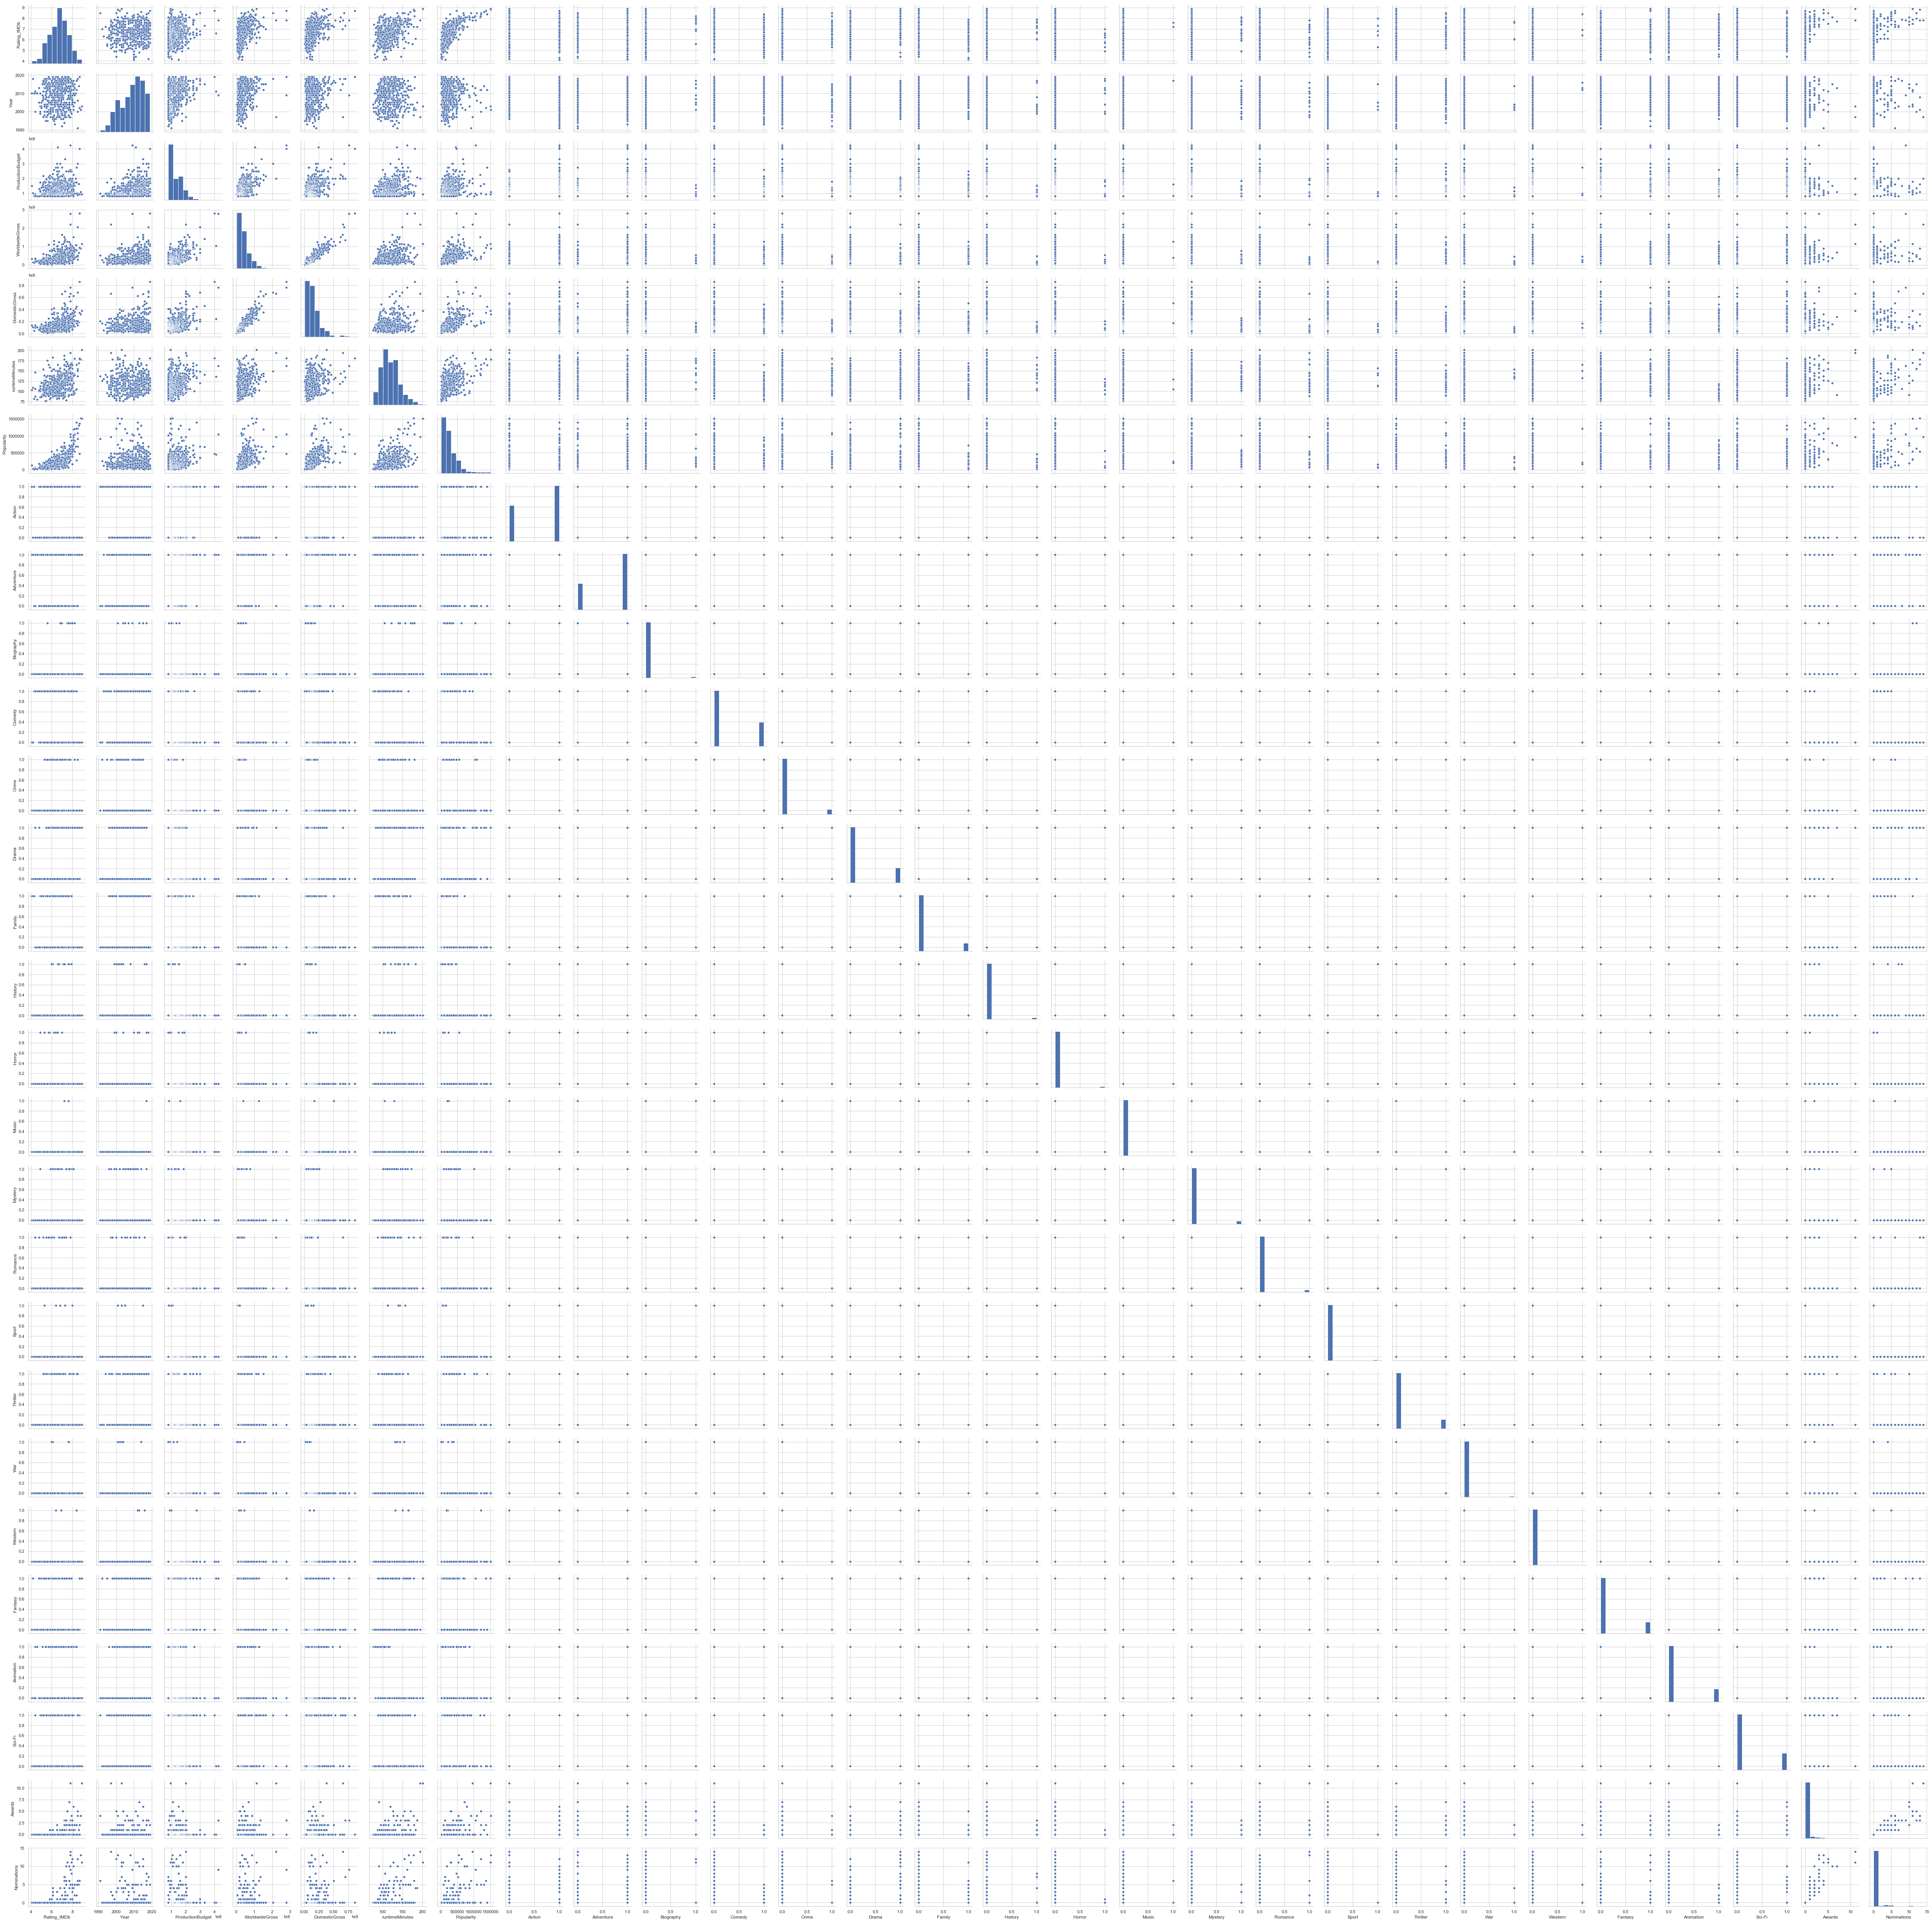

In [18]:
sns.pairplot(df_combo2);

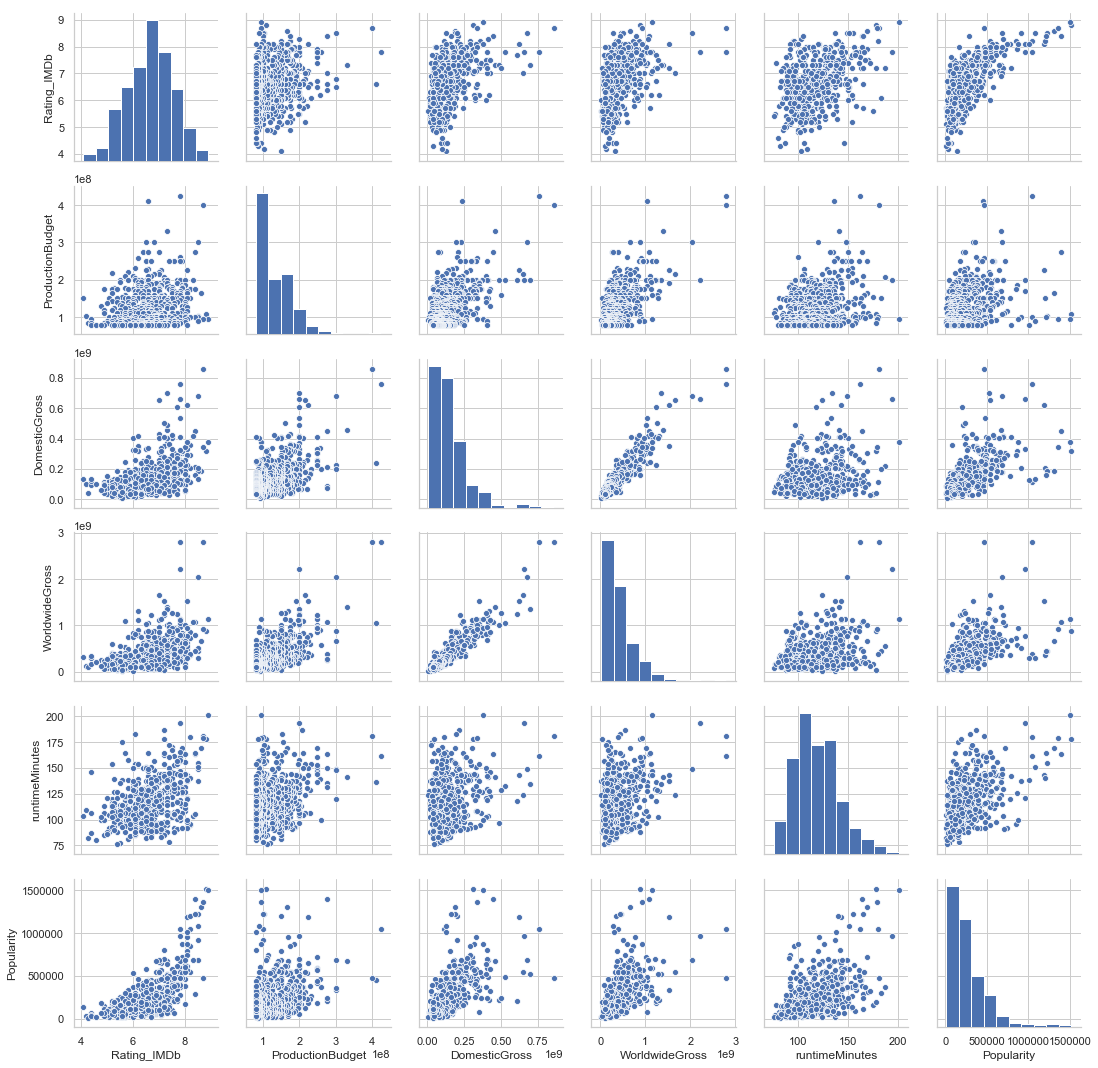

In [19]:
sns.pairplot(df_combo2[['Rating_IMDb', 'ProductionBudget', 'DomesticGross', 'WorldwideGross', "runtimeMinutes", "Popularity"]]);

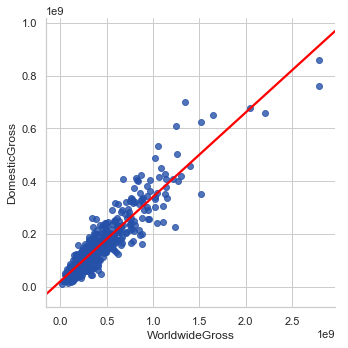

In [20]:
sns.lmplot(x='WorldwideGross', y= 'DomesticGross', ci=None, data=df_combo2,  palette="Set1", scatter_kws = {'color': '#2651A9'}, line_kws={'color': 'red'});
#scatter_kws = {'color': '#2651A9'}

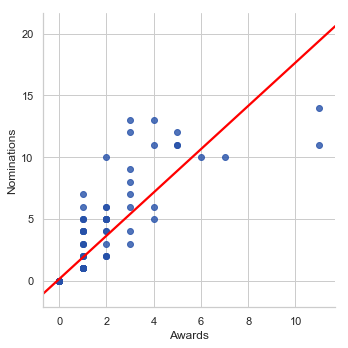

In [21]:
sns.lmplot(x='Awards', y= 'Nominations', ci=None, data=df_combo2,  palette="Set1", scatter_kws = {'color': '#2651A9'}, line_kws={'color': 'red'});


In [22]:
# Based on the lmplot, we conclude there is a strong correlation between two columns ("DomesticGross" and "WorldwideGross", "Awards and Nominations") 
# Exclude "DomesticGross", "Awards" according to Pairplot and Lasso
df_combo2 = df_combo2[['Rating_IMDb', 'Year', 'ProductionBudget','WorldwideGross', "runtimeMinutes", "Popularity", 'Action', 'Adventure', 'Biography', 'Comedy', "Crime", "Drama", "Family", "History", "Horror", "Music", "Mystery", "Romance", "Sport", "Thriller", "War", "Western", "Fantasy", "Animation", "Sci-Fi", "Nominations"]]

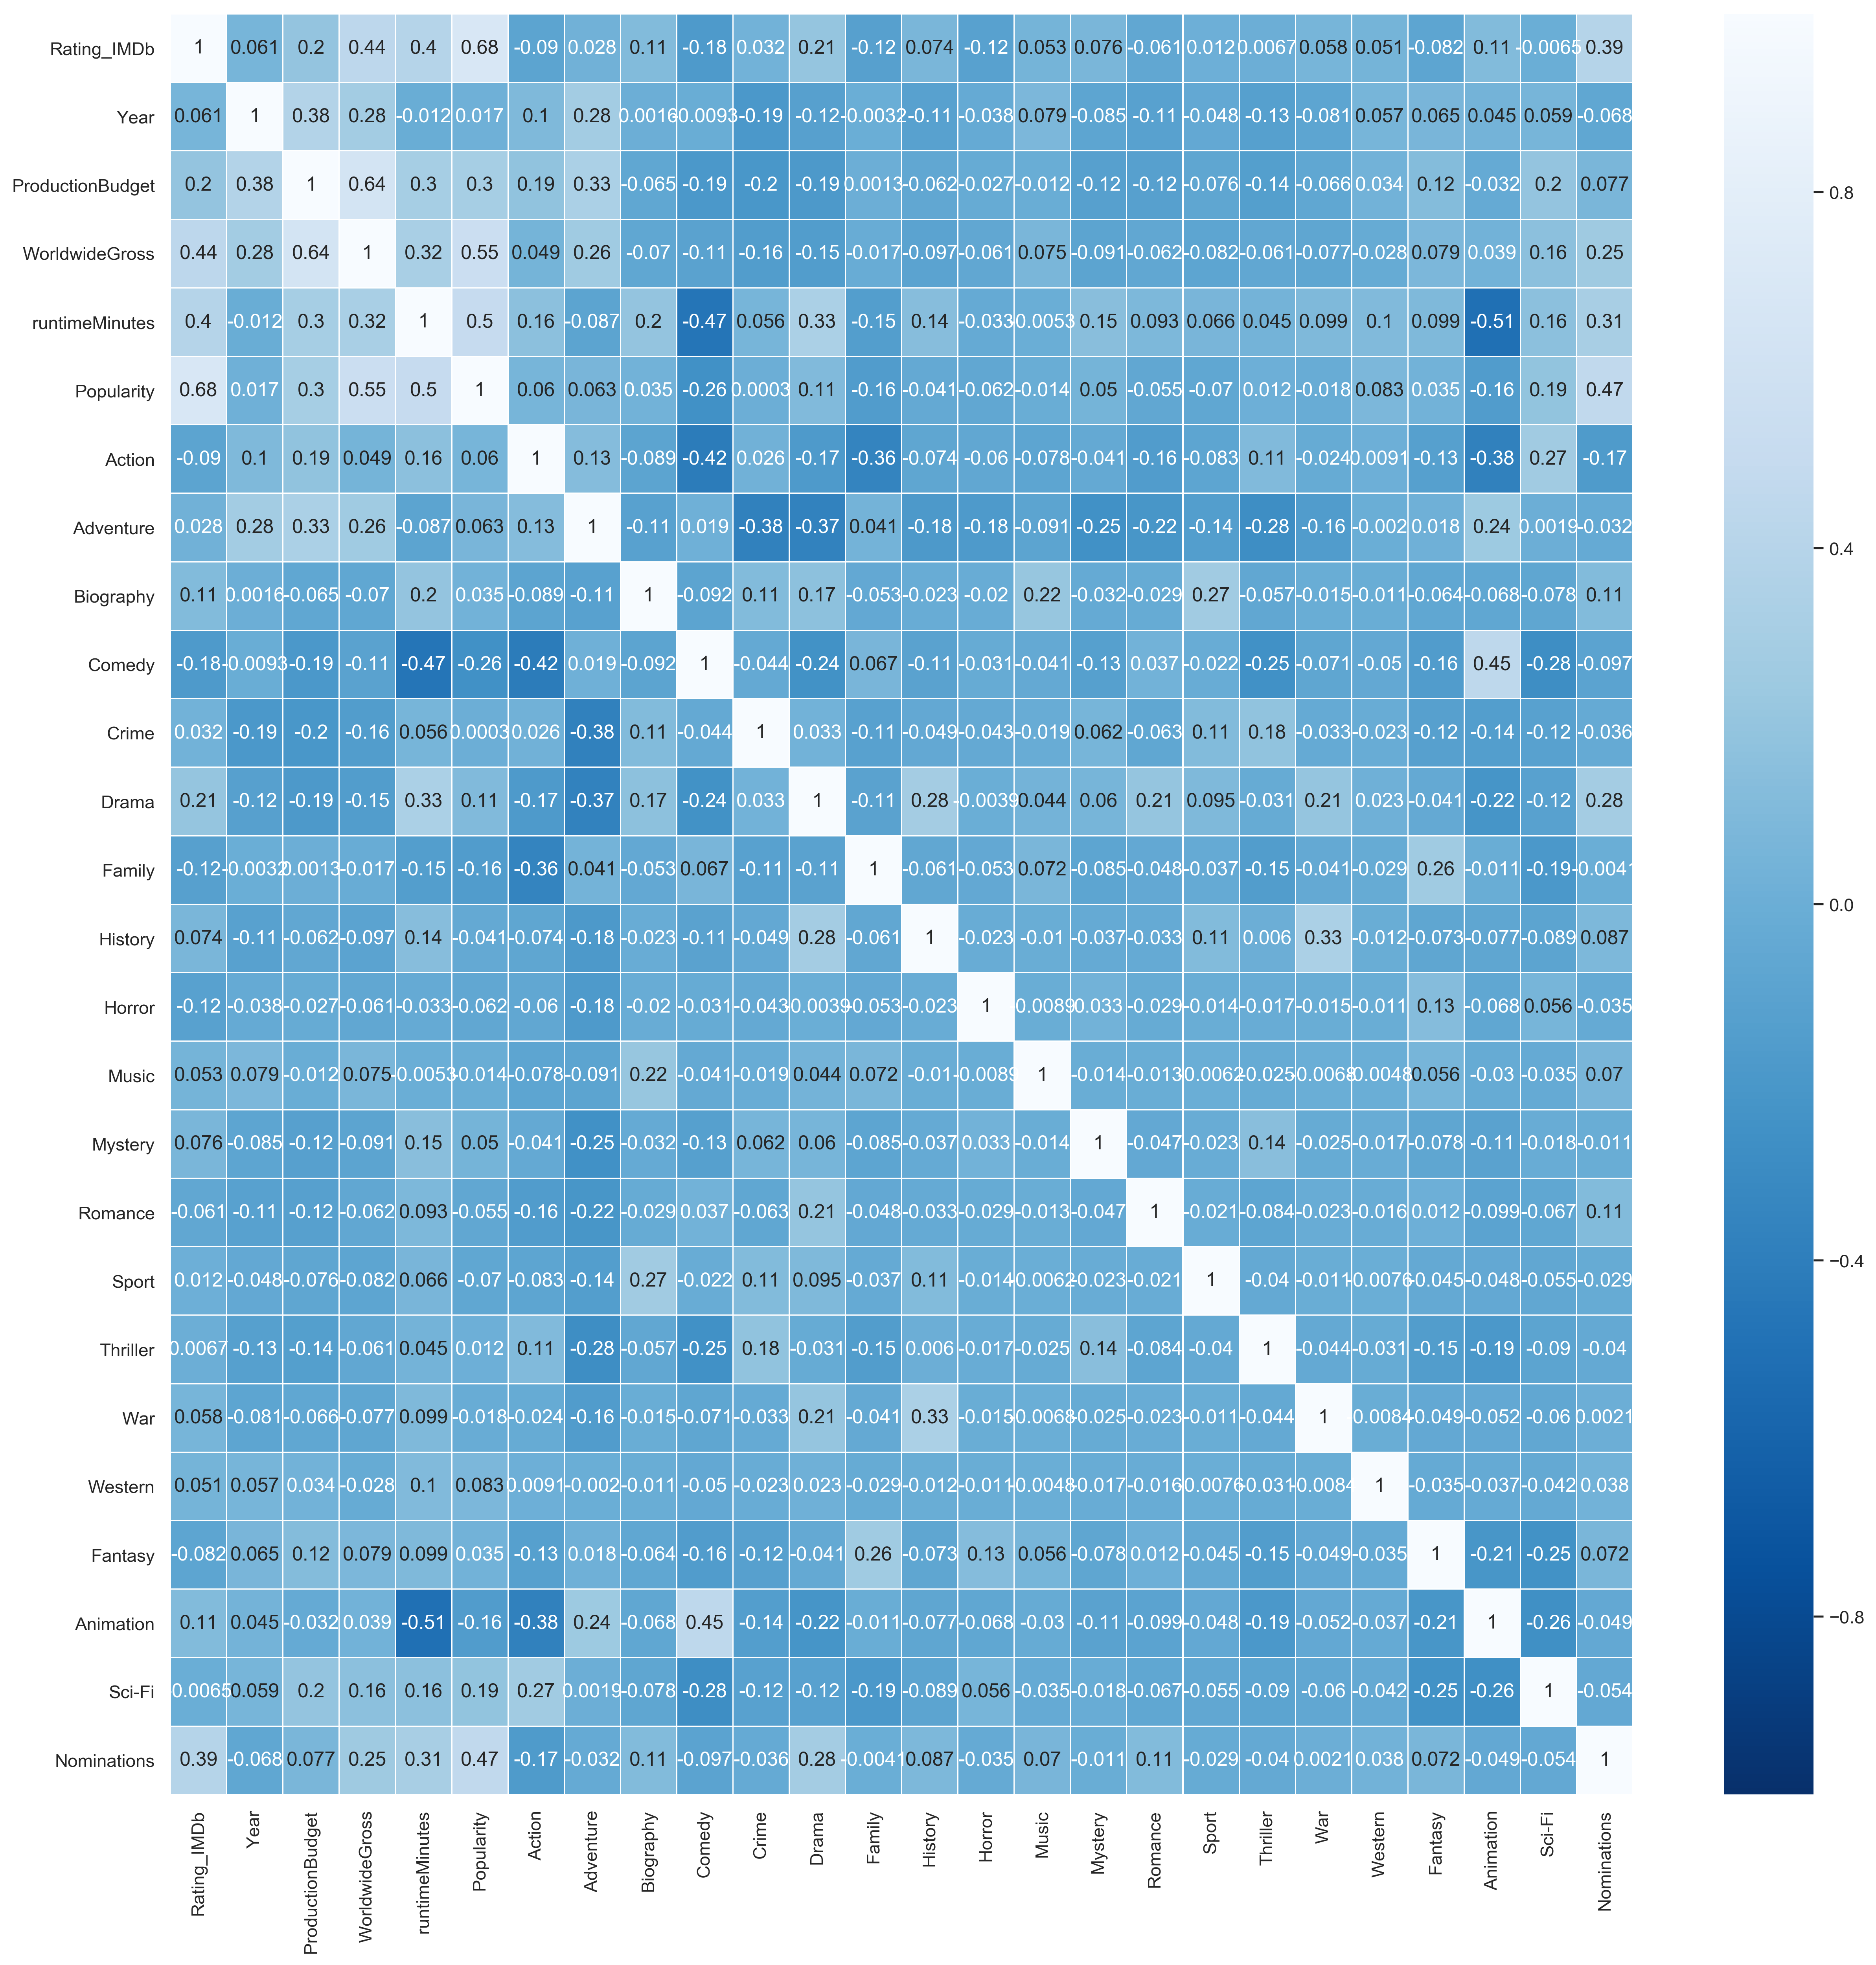

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (20, 20), dpi=300)
#sns.axes_style('ticks')
sns.heatmap(df_combo2.corr(), annot=True, vmin=-1, vmax=1, linewidths=.5, cmap="Blues_r" );

In [24]:
df_combo2.corr()['Rating_IMDb'].sort_values(ascending=False)

Rating_IMDb         1.000000
Popularity          0.681069
WorldwideGross      0.442653
runtimeMinutes      0.397030
Nominations         0.392327
Drama               0.205420
ProductionBudget    0.198164
Animation           0.111637
Biography           0.110922
Mystery             0.075771
History             0.074192
Year                0.060904
War                 0.057852
Music               0.053498
Western             0.050998
Crime               0.032281
Adventure           0.027751
Sport               0.012377
Thriller            0.006731
Sci-Fi             -0.006494
Romance            -0.061355
Fantasy            -0.081971
Action             -0.090256
Horror             -0.115970
Family             -0.119276
Comedy             -0.177900
Name: Rating_IMDb, dtype: float64

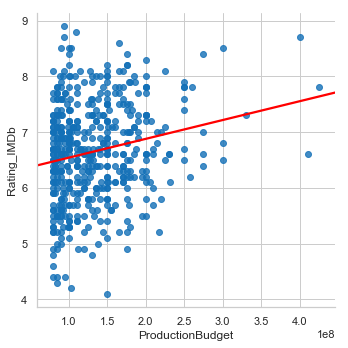

In [25]:
sns.lmplot(x='ProductionBudget', y= 'Rating_IMDb', ci=None, data=df_combo2,  palette="Set1", scatter_kws = {'color': '#1370B7'}, line_kws={'color': 'red'});

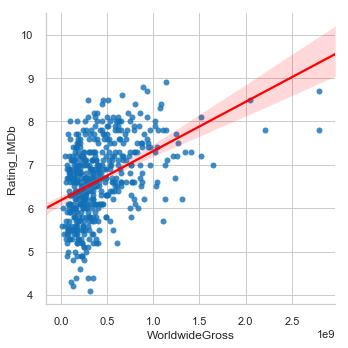

In [189]:
sns.lmplot(x='WorldwideGross', y= 'Rating_IMDb', data=df_combo2, scatter_kws = {'color': '#1370B7'}, line_kws={'color': 'red'});

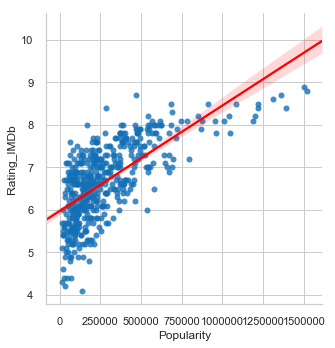

In [190]:
sns.lmplot(x='Popularity', y= 'Rating_IMDb', data=df_combo2,  palette="Set1", scatter_kws = {'color': '#1370B7'}, line_kws={'color': 'red'});
#ci = None

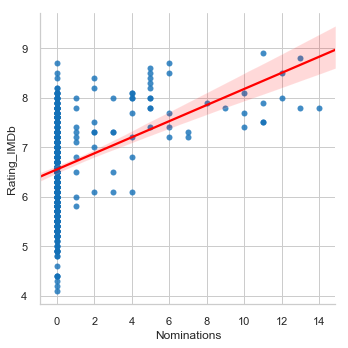

In [217]:
sns.lmplot(x="Nominations", y= 'Rating_IMDb', data=df_combo2,  palette="Set1", scatter_kws = {'color': '#1370B7'}, line_kws={'color': 'red'});
#ci = None

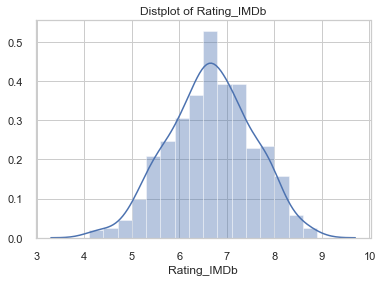

In [218]:
# Plot histogram of dependent variable to check if it is normal distribution
sns.distplot(df_combo2["Rating_IMDb"])
plt.title("Distplot of Rating_IMDb");

In [26]:
df_combo5 = df_combo2[["Rating_IMDb", "Popularity", "Animation", "Drama", "runtimeMinutes", "Crime"]]

# Basic regression model

In [27]:
#  Include all Values

x = df_combo2.drop('Rating_IMDb', axis=1)
y = df_combo2['Rating_IMDb']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Rating_IMDb   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     30.84
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           6.07e-84
Time:                        15:45:38   Log-Likelihood:                -415.47
No. Observations:                 511   AIC:                             882.9
Df Residuals:                     485   BIC:                             993.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -16.7274      8.844  

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Residuals Plot using Ridge (with only train and test data)

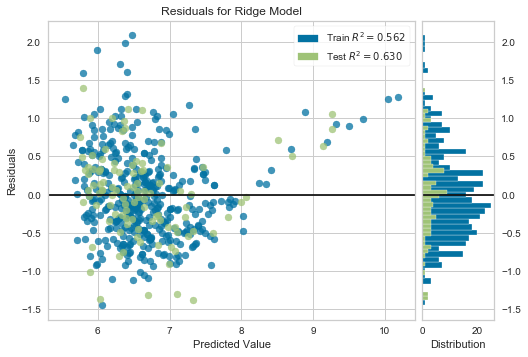

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

X = df_combo5.drop('Rating_IMDb', axis=1)
y = df_combo5['Rating_IMDb']

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();  

# Simple Validation Method: Train / Validation / Test

In [48]:
X, y = df_combo2.drop('Rating_IMDb',axis=1), df_combo2['Rating_IMDb']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()


#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.512
Ridge Regression val R^2: 0.512
Degree 2 polynomial regression val R^2: -0.398


In [50]:
#negative R^2, overfitting!
#Linear Regression on tesr data
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.553


# Cross-Validation / Test, KFold

In [51]:
from sklearn.model_selection import KFold

X, y = df_combo2.drop('Rating_IMDb',axis=1), df_combo2['Rating_IMDb']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')




Simple regression scores:  [0.49433055555611227, 0.4103837845277535, 0.6227447103240884, 0.6003534601081966, 0.5666345073658493]
Ridge scores:  [0.494691421133436, 0.41170629615726184, 0.6230132931220791, 0.6007342450042077, 0.5661185390445067] 

Simple mean cv r^2: 0.539 +- 0.078
Ridge mean cv r^2: 0.539 +- 0.077


In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm = LinearRegression()
lm.fit(X_scaled,y)
print(f'Simple regression test R^2: {lm.score(X_test_scaled, y_test):.3f}')

Simple regression test R^2: 0.553


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=10)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.551


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


# Lasso, LARS path

In [38]:
from sklearn.linear_model import lars_path
# Lasso without 
X = df_combo2[['Year', 'ProductionBudget','WorldwideGross', "runtimeMinutes", "Popularity", 'Action', 'Adventure', 'Biography', 'Comedy', "Crime", "Drama", "Family", "History", "Horror", "Music", "Mystery", "Romance", "Sport", "Thriller", "War", "Western", "Fantasy", "Animation", "Sci-Fi",  'Nominations']]
y = df_combo2["Rating_IMDb"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)
selected_columns = ['Year', 'ProductionBudget', 'WorldwideGross', "runtimeMinutes", "Popularity", 'Action', 'Adventure', 'Biography', 'Comedy', "Crime", "Drama", "Family", "History", "Horror", "Music", "Mystery", "Romance", "Sport", "Thriller", "War", "Western", "Fantasy", "Animation", "Sci-Fi",   'Nominations']
lasso_model = Lasso(alpha = 0.015) 
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

Computing regularization path using the LARS ...


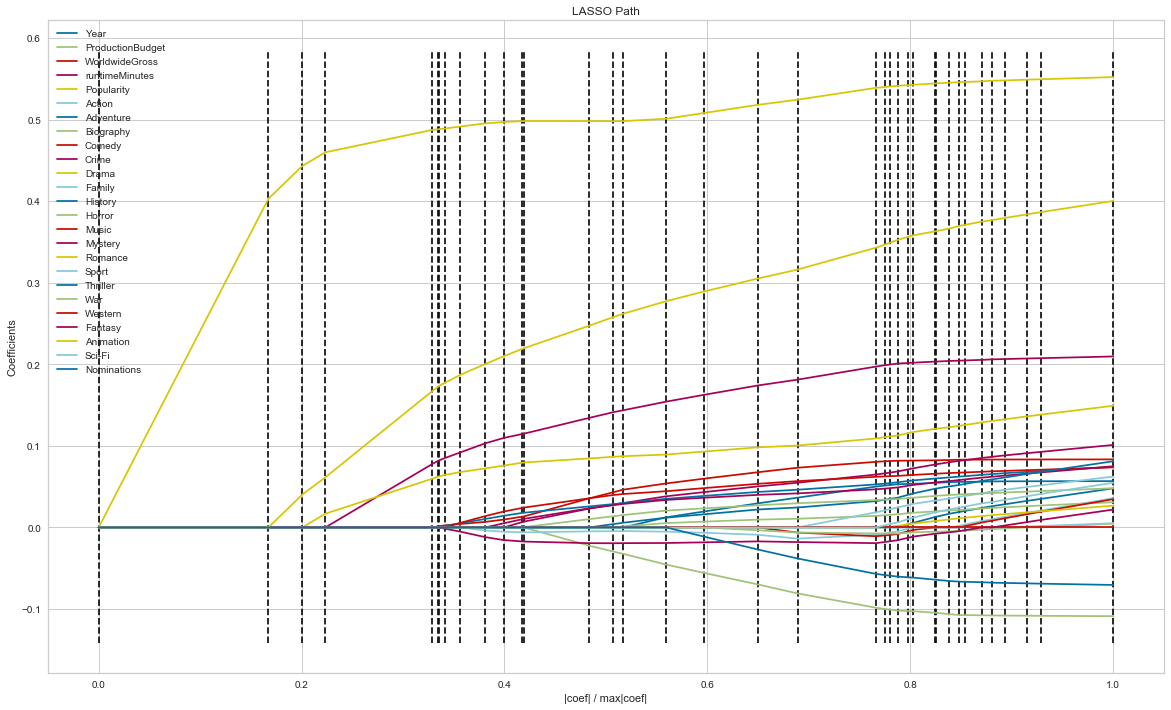

In [39]:
# plotting the LARS path + Lasso coef

plt.figure(figsize=(20,12))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [40]:
# print lasso coef using transformed data
lasso_model = Lasso(alpha = 0.015)
lasso_model.fit(X_tr,y_train)
list(zip(X_train.columns, lasso_model.coef_))

[('Year', 0.029096932557069945),
 ('ProductionBudget', -0.0691747313515799),
 ('WorldwideGross', 0.06730714457079552),
 ('runtimeMinutes', 0.17350190098859997),
 ('Popularity', 0.5175928357653683),
 ('Action', -0.008896392178118061),
 ('Adventure', -0.0),
 ('Biography', 0.009460394363284457),
 ('Comedy', -0.0),
 ('Crime', 0.04998906827306308),
 ('Drama', 0.0979641154153021),
 ('Family', 0.0),
 ('History', 0.04329851512578481),
 ('Horror', -0.0033037838031955685),
 ('Music', 0.05325859229110925),
 ('Mystery', 0.03977503452373192),
 ('Romance', -0.0),
 ('Sport', 0.0),
 ('Thriller', 0.021727206009137433),
 ('War', 0.026991726252215242),
 ('Western', 0.0),
 ('Fantasy', -0.01715886368082666),
 ('Animation', 0.3044080236901822),
 ('Sci-Fi', -0.0),
 ('Nominations', -0.026361855491666145)]

In [41]:
df_lasso2 = pd.DataFrame(list(zip(X_train.columns, lasso_model.coef_)), columns=["coef", "count"])
df_lasso2.sort_values("count", ascending=False, inplace=True)
df_lasso2.index = range(len(df_lasso2))

df_lasso2

coef     count
0         Popularity  0.517593
1          Animation  0.304408
2     runtimeMinutes  0.173502
3              Drama  0.097964
4     WorldwideGross  0.067307
5              Music  0.053259
6              Crime  0.049989
7            History  0.043299
8            Mystery  0.039775
9               Year  0.029097
10               War  0.026992
11          Thriller  0.021727
12         Biography  0.009460
13            Comedy -0.000000
14            Family  0.000000
15         Adventure -0.000000
16           Romance -0.000000
17             Sport  0.000000
18           Western  0.000000
19            Sci-Fi -0.000000
20            Horror -0.003304
21            Action -0.008896
22           Fantasy -0.017159
23       Nominations -0.026362
24  ProductionBudget -0.069175

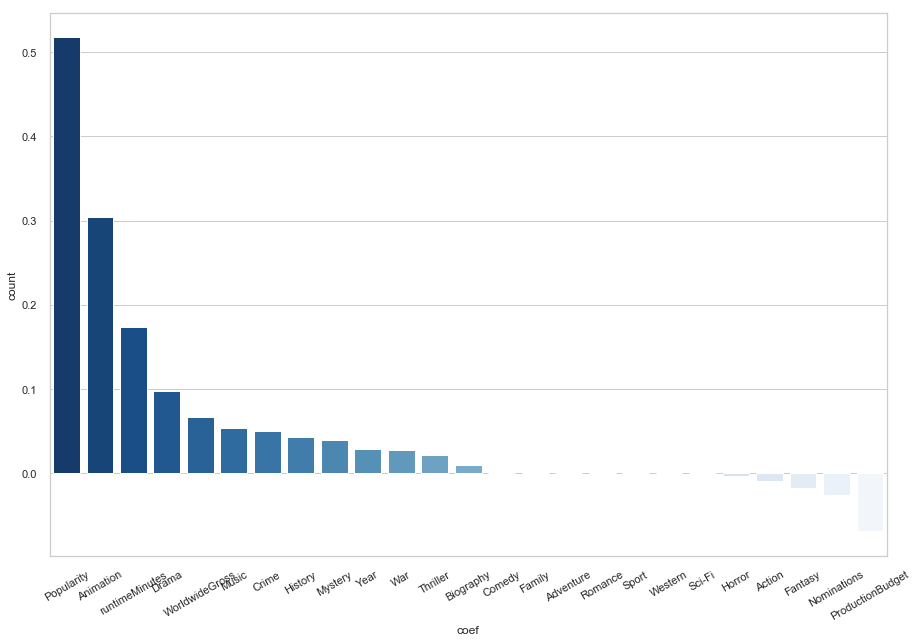

In [42]:
lasso_genres = df_lasso2.drop([0, 2, 4, 6, 23, 16, 23, 24])
lasso_contin = df_lasso2.drop([1, 3, 5, 6, 7, 8, 9,  10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,23,24])
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.barplot(x='coef', y= 'count', data=df_lasso2,  palette="Blues_r");
plt.xticks(rotation=30);
#rocket

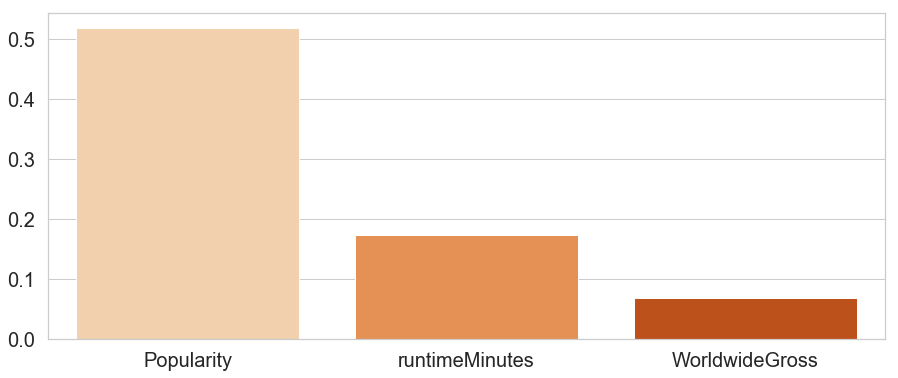

In [43]:

lasso_contin2 = lasso_contin.rename(columns={"runtimeMinutes": "RuntimeMinutes"})

plt.figure(figsize=(15, 6))
ax1 = sns.barplot(x='coef', y= 'count', data=lasso_contin2,  palette="Oranges");
plt.xticks( fontsize = 20)
plt.yticks(fontsize = 20)
ax1.set(xlabel='', ylabel='')
ax1.figure.savefig('STPENNSTA_byday23.png', bbox_inches = 'tight');


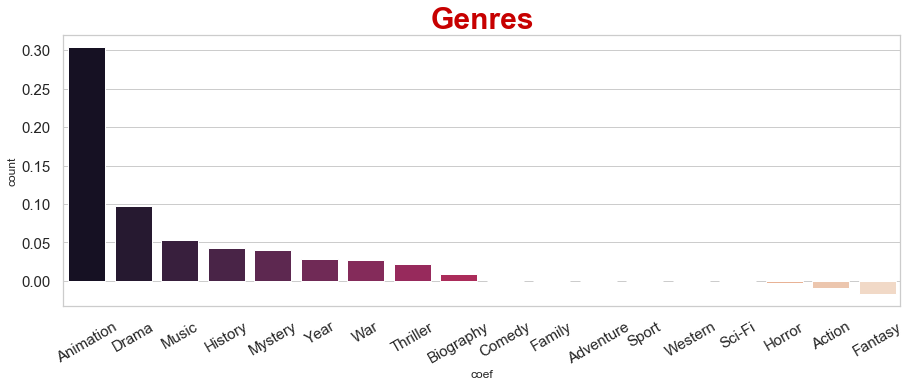

In [44]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 5))
sns.barplot(x='coef', y= 'count', data=lasso_genres,  palette="rocket");
plt.xticks(rotation=30, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Genres", fontsize = 30,weight='bold',color='#c70000');

# Basic regression model (data with lasso results)

In [45]:
#new dataset according to lasso results:
df_combo5 = df_combo2[["Rating_IMDb", "Popularity", "Animation", "Drama", "runtimeMinutes","WorldwideGross", "Crime", ]]


In [53]:
x = df_combo5.drop('Rating_IMDb', axis=1)
y = df_combo5['Rating_IMDb']

x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Rating_IMDb   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     117.8
Date:                Mon, 14 Oct 2019   Prob (F-statistic):           1.31e-92
Time:                        15:55:06   Log-Likelihood:                -434.64
No. Observations:                 511   AIC:                             883.3
Df Residuals:                     504   BIC:                             912.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.7665      0.181     26.

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


# Cross-Validation / Test, KFold (data with lasso results)

In [54]:
X, y = df_combo5.drop('Rating_IMDb',axis=1), df_combo5['Rating_IMDb']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression train R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression train R^2: {lm_poly.score(X_train_poly, y_train):.3f}')

#how it does on val data:
lm.fit(X,y)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')
lm_reg.fit(X,y)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val, y_val):.3f}')
lm_poly.fit(X,y)
print(f'Polynomial Regression val R^2: {lm_poly.score(X_val, y_val):.3f}')

#how it does on test data:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')
lm_reg.fit(X,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test, y_test):.3f}')
lm_poly.fit(X,y)
print(f'Polynomial Regression test R^2: {lm_poly.score(X_test, y_test):.3f}')

Linear Regression train R^2: 0.598
Ridge Regression train R^2: 0.598
Degree 2 polynomial regression train R^2: 0.595
Linear Regression val R^2: 0.569
Ridge Regression val R^2: 0.570
Polynomial Regression val R^2: 0.569
Linear Regression test R^2: 0.552
Ridge Regression test R^2: 0.552
Polynomial Regression test R^2: 0.552


/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=5.95125e-19): result may not be accur